In [1]:
import pandas as pd
import numpy as np

# Define the range of latitude and longitude values
lat_values = np.arange(6.25, 37.25, 0.5)
lon_values = np.arange(38.25, 99.25, 0.5)

# Create a meshgrid of latitude and longitude values
lat_grid, lon_grid = np.meshgrid(lat_values, lon_values)

# Flatten the meshgrid arrays to create a table of unique lat/lon pairs
lat_lon_pairs = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])

# Create a DataFrame from the lat/lon pairs
df = pd.DataFrame(lat_lon_pairs, columns=['lat', 'lon'])

# Display the DataFrame
df.to_csv("grid_0p50.csv")

In [ ]:
import pandas as pd
from scipy.spatial import cKDTree

# Load grid points file
grid_df = pd.read_csv("grid_0p50.csv")  # Grid centers with 'lat' and 'lon' columns

###########################################################################################################
## Download the fire data file from the provided URL https://firms.modaps.eosdis.nasa.gov/download/  ######
## Note: The fire data file should be downloaded and saved as "fire_archive_M-C61_570219.csv"        ######
###########################################################################################################


# Load fire data file
fire_df = pd.read_csv("fire_archive_M-C61_570219.csv")  # Fire data with 'latitude' and 'longitude' columns
# Filter data by confidence
fire_df = fire_df[fire_df['confidence'] > 75]

# Ensure column names match
assert 'lat' in grid_df.columns and 'lon' in grid_df.columns, "Grid file must have 'lat' and 'lon' columns"
assert 'latitude' in fire_df.columns and 'longitude' in fire_df.columns, "Fire file must have 'latitude' and 'longitude' columns"

# Create KDTree using grid coordinates
grid_tree = cKDTree(grid_df[['lat', 'lon']].values)

# Find the nearest grid point for each fire point
distances, indices = grid_tree.query(fire_df[['latitude', 'longitude']].values)

# Assign nearest grid lat/lon to fire data
fire_df['grid_lat'] = grid_df.iloc[indices]['lat'].values
fire_df['grid_lon'] = grid_df.iloc[indices]['lon'].values

# Save updated fire data with grid assignments
fire_df.to_csv("fire_data_with_grid_50.csv", index=False)

# Display results
print(fire_df[['latitude', 'longitude', 'grid_lat', 'grid_lon']].head(10))


    latitude  longitude  grid_lat  grid_lon
1    26.9708    95.6775     26.75     95.75
2    26.9694    95.6878     26.75     95.75
4    26.9154    95.3308     26.75     95.25
5    26.8176    95.3756     26.75     95.25
6    26.8161    95.3871     26.75     95.25
20   26.4490    94.9861     26.25     94.75
23   26.6455    95.1637     26.75     95.25
24   26.6471    95.1564     26.75     95.25
44   18.6520    73.8160     18.75     73.75
66   17.7225    75.3808     17.75     75.25


In [3]:
# Import required libraries
import pandas as pd

# Load CSV data
df = pd.read_csv('fire_data_with_grid_50.csv')

# Group by unique latitude, longitude pairs, and acquisition date
grouped = df.groupby(['grid_lat', 'grid_lon', 'acq_date'])

# Calculate number of rows and sum of "frp" values
result = grouped.agg(
    count=('frp', 'size'),
    sum_frp=('frp', 'sum')
).reset_index()

df = result

# Convert acq_date to datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Extract year and month from acq_date
df['year_month'] = df['acq_date'].dt.to_period('M')

# Group by year_month and aggregate count and sum_frp
monthly_df = df.groupby(['grid_lat', 'grid_lon', 'year_month']).agg(
    count=('count', 'sum'),
    sum_frp=('sum_frp', 'sum')
).reset_index()

print(monthly_df)
monthly_df.to_csv("month_fire_0p50.csv")

       grid_lat  grid_lon year_month  count  sum_frp
0          6.75     93.75    2005-03      1     75.9
1          6.75     93.75    2008-02      2     17.3
2          8.25     77.25    2002-02      1     26.8
3          8.25     77.25    2002-03      2     22.1
4          8.25     77.25    2003-01      1     38.1
...         ...       ...        ...    ...      ...
50864     34.75     74.75    2017-10      4    206.7
50865     34.75     74.75    2020-11      2     78.5
50866     34.75     75.25    2007-10      4    158.7
50867     34.75     75.25    2007-11      1     20.1
50868     34.75     75.25    2017-10      1     14.5

[50869 rows x 5 columns]


In [4]:
import pandas as pd

# Load the data (modify the filename accordingly)
df = pd.read_csv("month_fire_0p50.csv")

# Convert 'year_month' to datetime format
df['year_month'] = pd.to_datetime(df['year_month'])

# Get the start and end month
start_month = df['year_month'].min()
end_month = df['year_month'].max()

print("Start Month:", start_month.strftime('%Y-%m'))
print("End Month:", end_month.strftime('%Y-%m'))


Start Month: 2001-01
End Month: 2024-07


In [ ]:
import xarray as xr
import numpy as np

# Define latitude and longitude boundaries
lat_min, lat_max = 6, 36.5
lon_min, lon_max = 68, 98.5

#######################################################################################################################
# Download the MODIS NetCDF file from the provided URL  https://icdc.cen.uni-hamburg.de/thredds/catalog/ftpthredds/modis_vcf/global_0.5deg/catalog.html
# Note: The NetCDF file should be downloaded and saved as "MODIS-TERRA_C6.1__MOD44B__ForestCoverFraction__LPDAAC__GLOBAL__0.5degree__UHAM-ICDC__20000305__fv0.01.nc"
#######################################################################################################################

# Load the NetCDF file
file_path = "MODIS-TERRA_C6.1__MOD44B__ForestCoverFraction__LPDAAC__GLOBAL__0.5degree__UHAM-ICDC__20000305__fv0.01.nc"  # Replace with your actual file path
ds = xr.open_dataset(file_path)

# Subset the dataset based on latitude and longitude
ds_subset = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Convert to DataFrame
df = ds_subset.to_dataframe().reset_index()

df = df.drop(columns=['time'])

df.to_csv("forestcover.csv")


In [ ]:
import pandas as pd

########################################################################################################################################
##### The below file has grids with forest cover fraction values greater than 10% and lie inside the Indian geographical boundaries. ###
##### This processing step was carried in GIS software #####
########################################################################################################################################

# Load the pre-processed grid data with forest cover fraction
df_final = pd.read_csv("merged_data_grids.csv")

# Load the data (modify the filename accordingly)
df = pd.read_csv("month_fire_0p50.csv")
# Rename columns
df= df.rename(columns={'grid_lat': 'lat', 'grid_lon': 'lon'})


# Merge to keep only matching lat-lon pairs
df_filtered = pd.merge(df_final ,df ,on=['lat', 'lon'], how='inner')

# List of columns to keep
columns_to_keep = ['lat', 'lon','forestcoverfraction','year_month','count','sum_frp']

# Keep only the specified columns
df_filtered = df_filtered[columns_to_keep]

df_filtered.to_csv('above_10_fc_w_fire.csv') # Above 10% forest cover with fire data


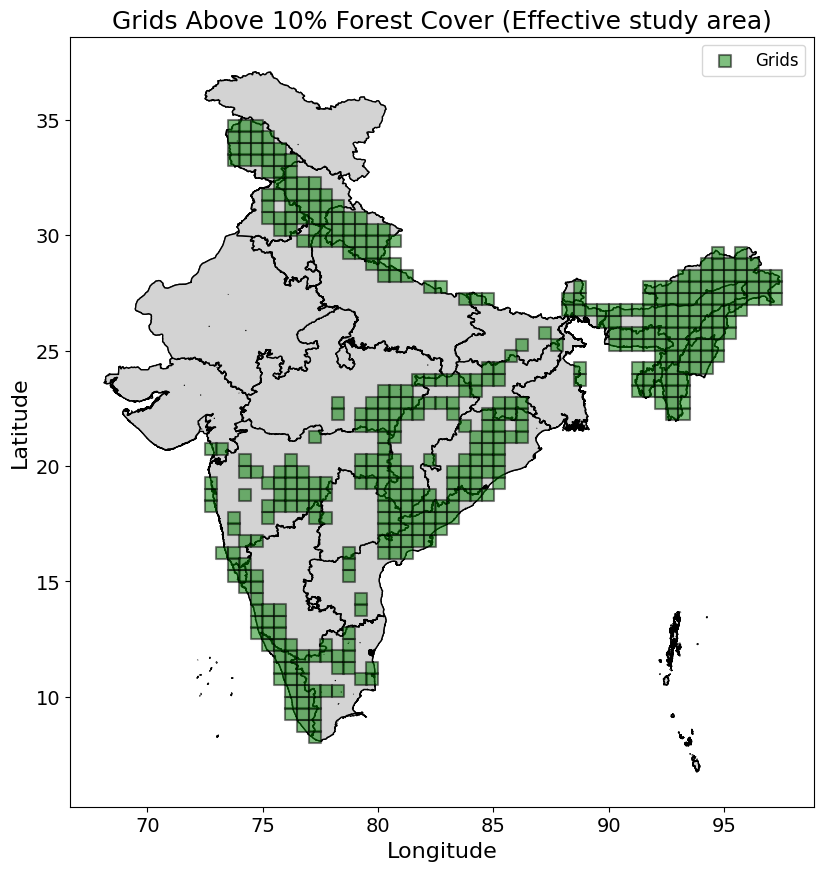

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the India shapefile
india_shapefile = "india.shp" ############ Extarct the shapefile from the zip file  ###############
india_map = gpd.read_file(india_shapefile)

# Load the forest fire data file
fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract unique latitude-longitude pairs
unique_fire_data = fire_data[['lat', 'lon']].drop_duplicates()

latitudes = unique_fire_data['lat']
longitudes = unique_fire_data['lon']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot India map
india_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot fire data points as square markers with borders
plt.scatter(
    longitudes,
    latitudes,
    color='green',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',  # Black borders around squares
    linewidth=1.5,
    label="Grids"
)

plt.title("Grids Above 10% Forest Cover (Effective study area)", fontsize=18)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.legend(fontsize=12)

# Save the figure as a high-DPI PNG
plt.savefig("Grids_fc_above_10.png", dpi=500, bbox_inches='tight')
plt.show()



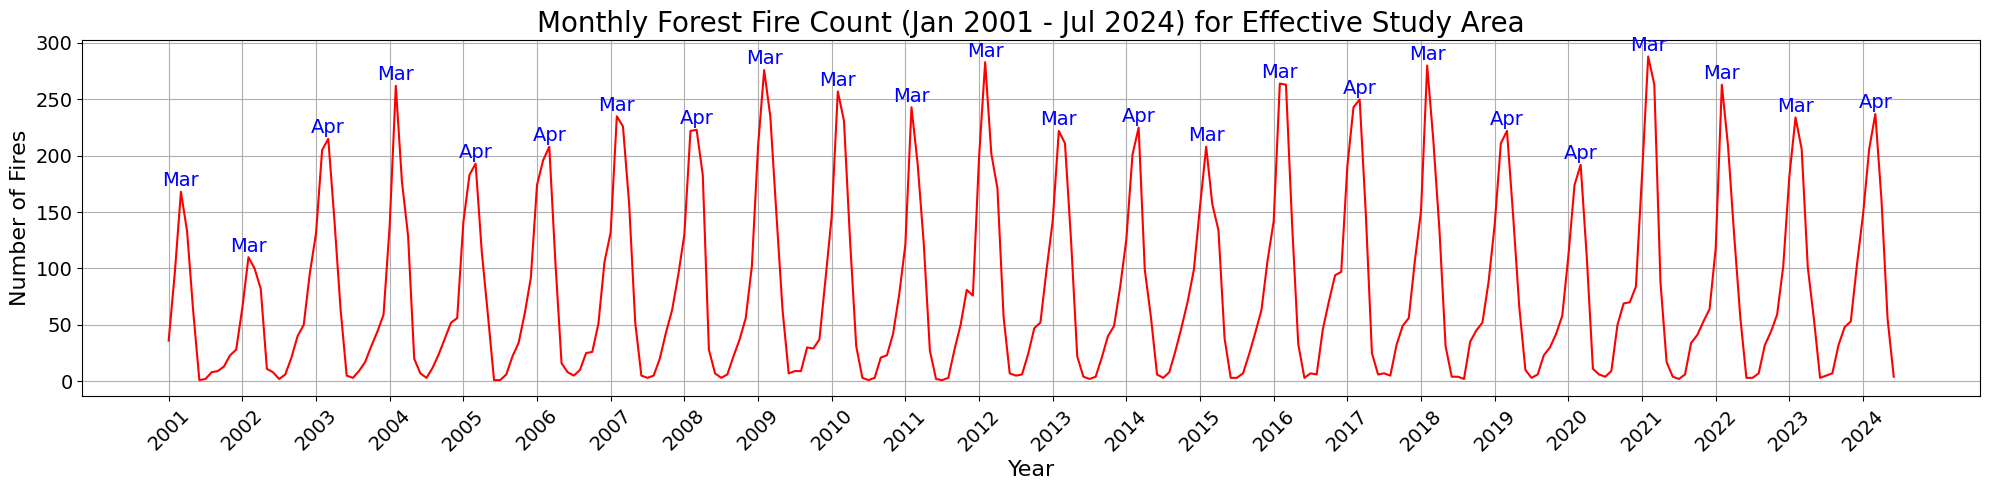

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the forest fire data file
fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Group data by year_month and count fire occurrences
monthly_fire_counts = fire_data.groupby('year_month')['count'].size().reset_index(name='fire_count')

# Extract the year from the year_month column for cleaner x-axis labels
monthly_fire_counts['year'] = monthly_fire_counts['year_month'].str[:4]
monthly_fire_counts['month'] = monthly_fire_counts['year_month'].str[5:7]

# Find the top month (maximum fire count) per year
top_month_per_year = monthly_fire_counts.loc[monthly_fire_counts.groupby('year')['fire_count'].idxmax()]

# Map month numbers to three-letter month names
month_map = {
    "01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr",
    "05": "May", "06": "Jun", "07": "Jul", "08": "Aug",
    "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"
}
top_month_per_year['month_name'] = top_month_per_year['month'].map(month_map)

# Plot the time series
plt.figure(figsize=(20, 5))
plt.plot(monthly_fire_counts['year_month'], monthly_fire_counts['fire_count'], color='red', linewidth=1.5)

# Format the plot
plt.title("Monthly Forest Fire Count (Jan 2001 - Jul 2024) for Effective Study Area", fontsize=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Number of Fires", fontsize=16)

# Show only the year on the x-axis
plt.xticks(
    ticks=monthly_fire_counts['year_month'][::12],  # Show ticks at yearly intervals
    labels=monthly_fire_counts['year'][::12],
    rotation=45,
    fontsize=14
)
plt.yticks(fontsize=14)

# Annotate top month for each year
for _, row in top_month_per_year.iterrows():
    plt.text(row['year_month'], row['fire_count'] + 5,
             f"{row['month_name']}",
             ha='center', fontsize=14, color='blue')

plt.grid(True)
plt.tight_layout()
# Save the figure as a high-DPI PNG
plt.savefig("monthly_timeseries.png", dpi=500, bbox_inches='tight')
plt.show()


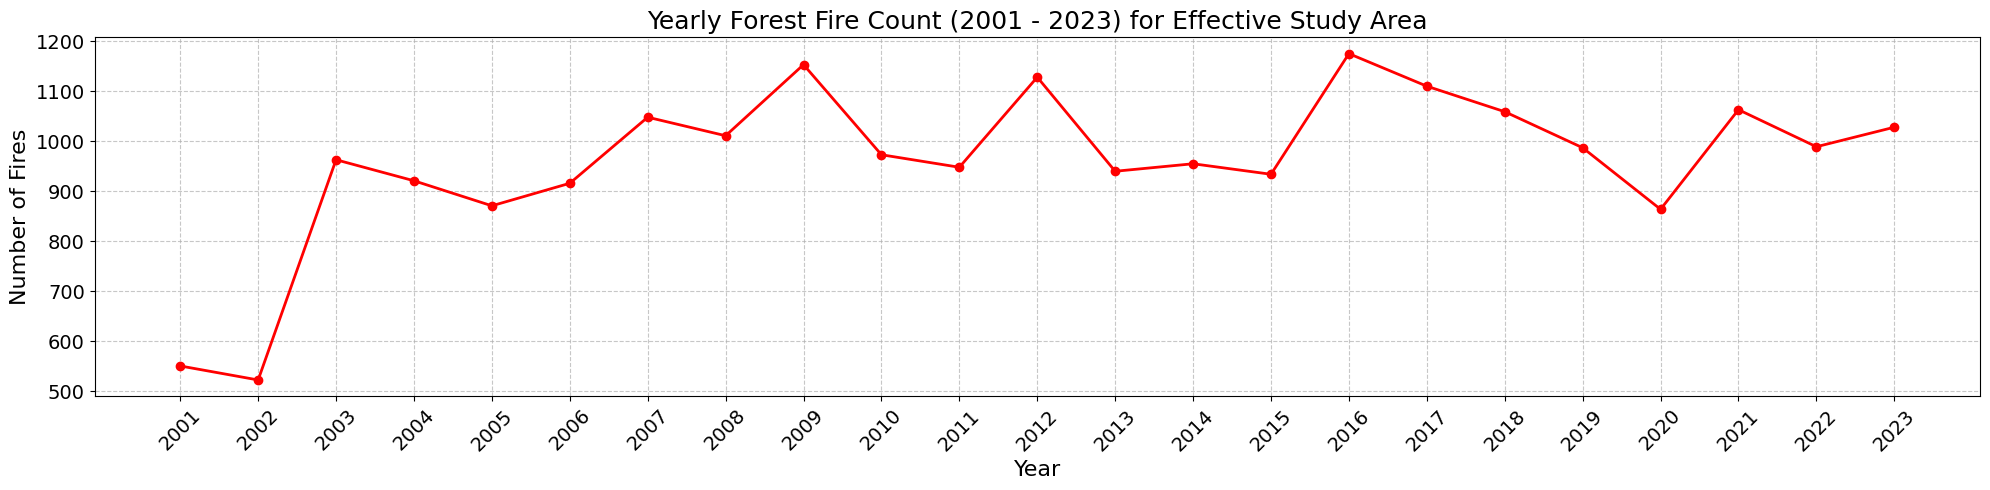

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the forest fire data file
fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract the year from the year_month column
fire_data['year'] = fire_data['year_month'].str[:4]

# Filter out 2024 data
fire_data = fire_data[fire_data['year'] != "2024"]

# Group data by year and count fire occurrences
yearly_fire_counts = fire_data.groupby('year').size().reset_index(name='fire_count')

# Plot the time series
plt.figure(figsize=(20, 5))
plt.plot(yearly_fire_counts['year'], yearly_fire_counts['fire_count'], marker='o', linestyle='-', color='red', linewidth=2)

# Format the plot
plt.title("Yearly Forest Fire Count (2001 - 2023) for Effective Study Area", fontsize=18)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Number of Fires", fontsize=16)

# Show only the year on the x-axis
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure as a high-DPI PNG
plt.savefig("yearly_timeseries_till_2023.png", dpi=500, bbox_inches='tight')
plt.show()


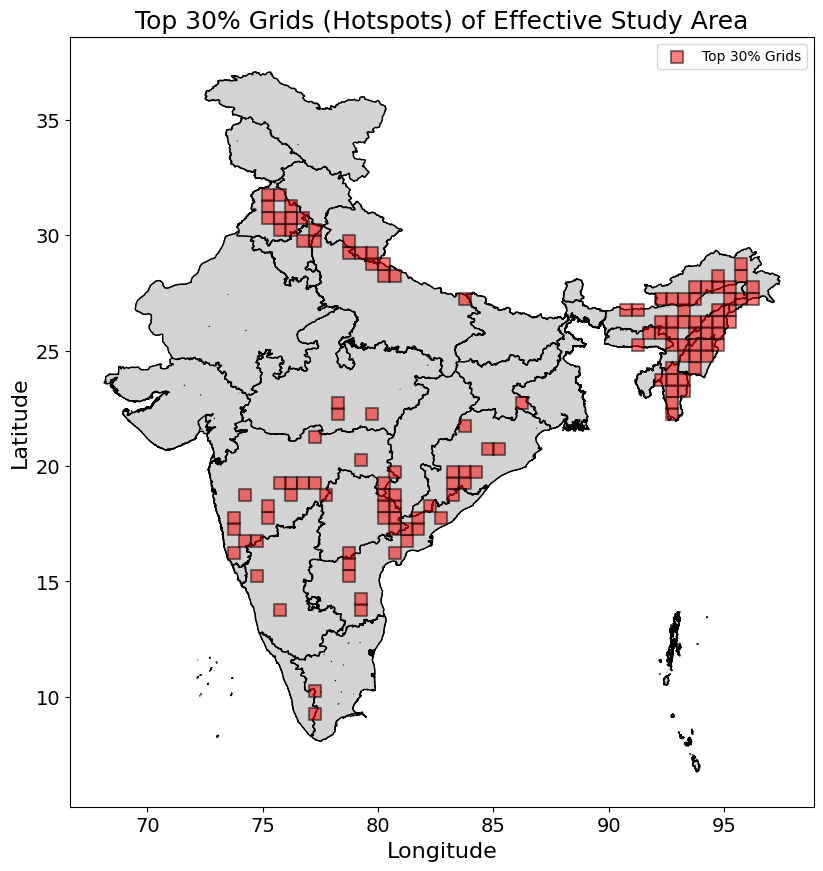

In [13]:
import pandas as pd

# Load the forest fire data file
fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Step 1: Count total fires per (lat, lon) grid
grid_fire_counts = fire_data.groupby(['lat', 'lon']).size().reset_index(name='total_fires')

# Step 2: Calculate the top 10% grids by fire count
top_10_percent_threshold = int(len(grid_fire_counts) * 0.3)
top_grids = grid_fire_counts.sort_values('total_fires', ascending=False).head(top_10_percent_threshold)

# Step 3: Filter the original data to keep only top 10% grids
top_grids_data = fire_data.merge(top_grids[['lat', 'lon']], on=['lat', 'lon'])

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the India shapefile
india_shapefile = "india.shp"
india_map = gpd.read_file(india_shapefile)
 
fire_data = top_grids_data
# Extract unique latitude-longitude pairs
unique_fire_data = fire_data[['lat', 'lon']].drop_duplicates()

latitudes = unique_fire_data['lat']
longitudes = unique_fire_data['lon']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot India map
india_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot fire data points as square markers with borders
plt.scatter(
    longitudes,
    latitudes,
    color='red',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',  # Black borders around squares
    linewidth=1.5,
    label="Top 30% Grids"
)

# Add labels and legend
plt.title("Top 30% Grids (Hotspots) of Effective Study Area",fontsize=18)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()

# Save the figure as a high-DPI PNG
plt.savefig("top30.png", dpi=500, bbox_inches='tight')
plt.show()


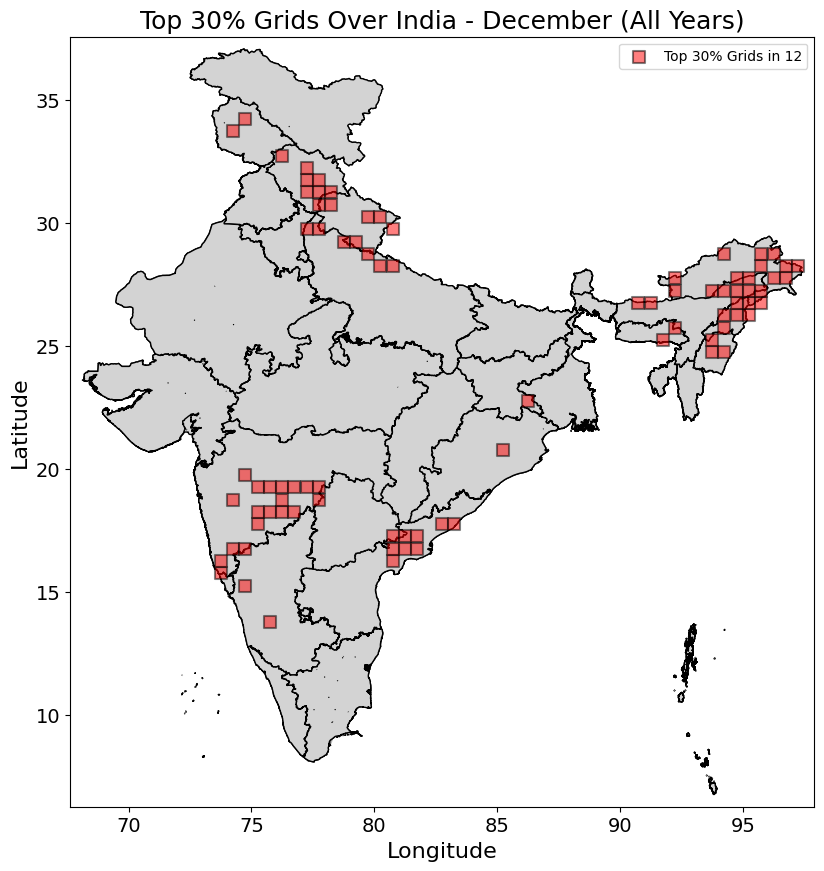

In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load India shapefile
india_shapefile = "india.shp"
india_map = gpd.read_file(india_shapefile)

# Load the fire data
fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract year and month
fire_data['year'] = fire_data['year_month'].str[:4]
fire_data['month'] = fire_data['year_month'].str[5:7]

# Count fires per grid per month
monthly_grid_counts = (
    fire_data.groupby(['month', 'lat', 'lon'])
    .size()
    .reset_index(name='fire_count')
)

# Identify the top 10% grids per month
top_30_percent_monthly = pd.DataFrame()

for month in monthly_grid_counts['month'].unique():
    month_data = monthly_grid_counts[monthly_grid_counts['month'] == month]
    threshold = month_data['fire_count'].quantile(0.7)
    top_grids = month_data[month_data['fire_count'] >= threshold]
    top_30_percent_monthly = pd.concat([top_30_percent_monthly, top_grids])

# Get sorted unique months
months = sorted(top_30_percent_monthly['month'].unique())

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))
india_map.plot(ax=ax, color='#fafafa', edgecolor='black')

# Function to update the plot for each month's top 10% data
def update(month):
    ax.clear()
    india_map.plot(ax=ax, color='lightgrey', edgecolor='black')

    # Filter for the top 10% grids of the current month
    month_data = top_30_percent_monthly[top_30_percent_monthly['month'] == month]
    unique_fire_data = month_data[['lat', 'lon']].drop_duplicates()

    # Plot fire locations
    ax.scatter(
        unique_fire_data['lon'],
        unique_fire_data['lat'],
        color='red',
        s=70,
        marker='s',
        alpha=0.5,
        edgecolor='black',
        linewidth=1.5,
        label=f"Top 30% Grids in {month}"
    )

    # Format the plot
    month_names = {
        "01": "January", "02": "February", "03": "March", "04": "April",
        "05": "May", "06": "June", "07": "July", "08": "August",
        "09": "September", "10": "October", "11": "November", "12": "December"
    }
    ax.set_title(f"Top 30% Grids Over India - {month_names[month]} (All Years)", fontsize=18)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)
    ax.legend()

    # Increase tick font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([india_map.total_bounds[0] - 0.5, india_map.total_bounds[2] + 0.5])
    ax.set_ylim([india_map.total_bounds[1] - 0.5, india_map.total_bounds[3] + 0.5])

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=months, repeat=True)

# Save as an animated GIF (optional)
ani.save('top_30_percent_fires_animation.gif', writer='pillow', fps=1)

plt.show()


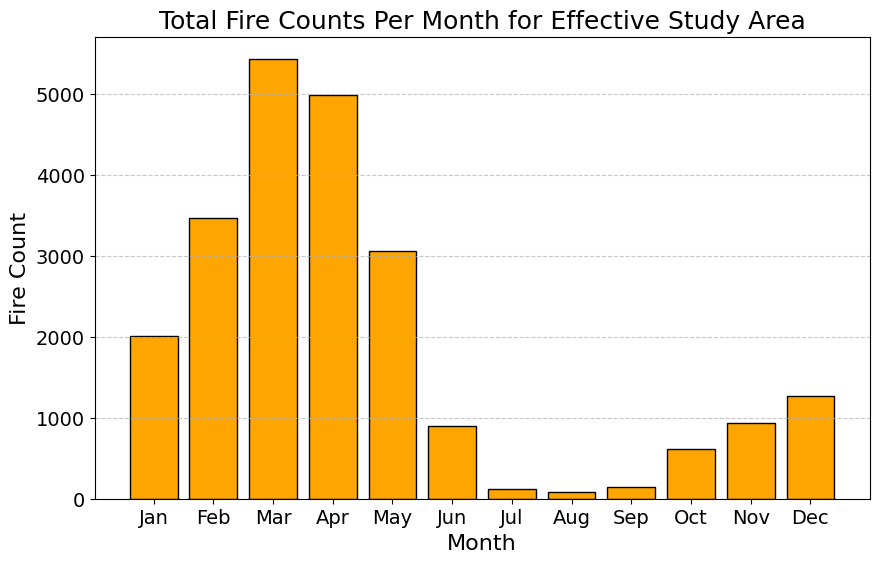

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the original forest fire data file
fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract the month from year_month
fire_data['month'] = fire_data['year_month'].str[5:7]

# Map month numbers to three-letter month names
month_map = {
    "01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr",
    "05": "May", "06": "Jun", "07": "Jul", "08": "Aug",
    "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"
}
fire_data['month_name'] = fire_data['month'].map(month_map)

# Count total fires per month
monthly_fire_count = fire_data.groupby('month_name').size().reindex(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_fire_count.index, monthly_fire_count.values, color='orange', edgecolor='black')

# Add labels, title, and grid
plt.title("Total Fire Counts Per Month for Effective Study Area", fontsize=18)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Fire Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the bar graph
# Save the figure as a high-DPI PNG
plt.savefig("month_bar.png", dpi=500, bbox_inches='tight')
plt.show()


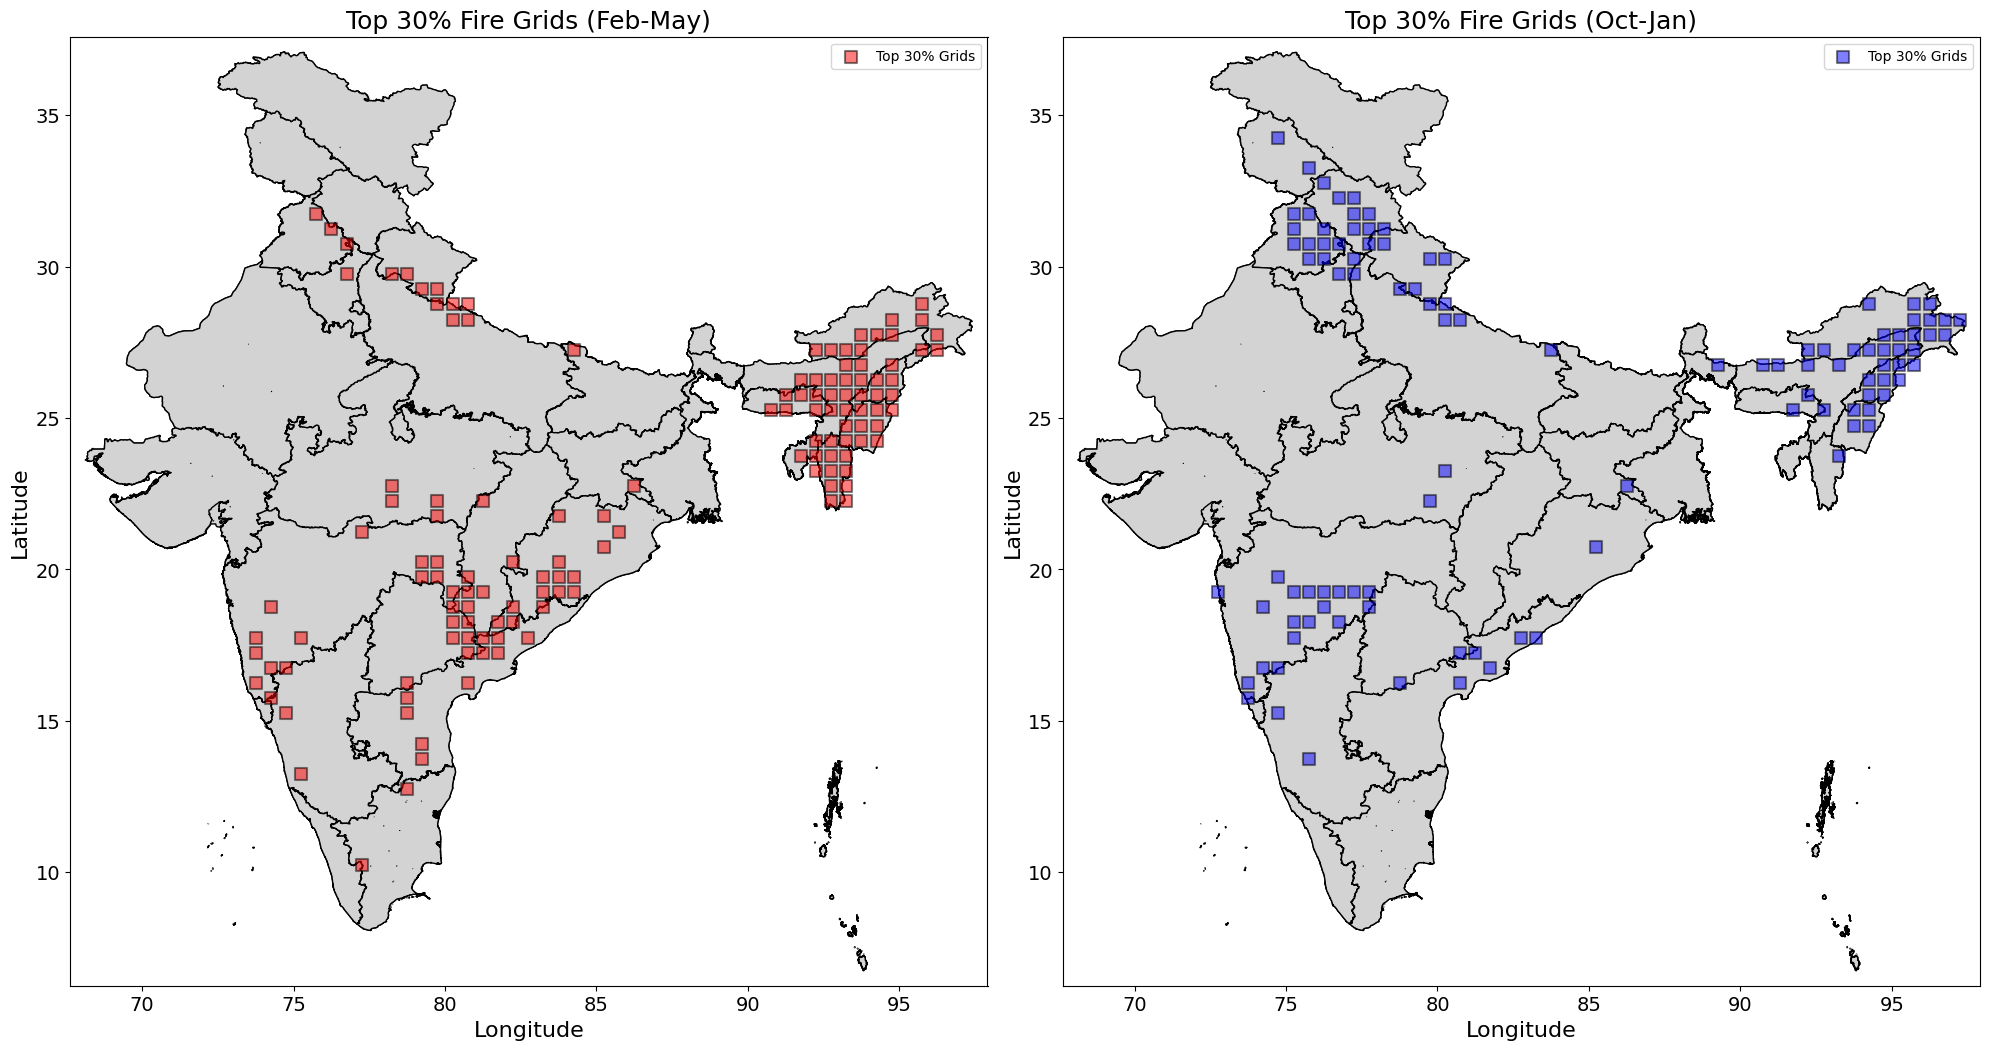

In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load India shapefile
india_shapefile = "india.shp"
india_map = gpd.read_file(india_shapefile)

# Load the fire data
fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract year and month
fire_data['year'] = fire_data['year_month'].str[:4]
fire_data['month'] = fire_data['year_month'].str[5:7]

# Define the two seasonal groups
spring_months = ["02", "03", "04", "05"]
winter_months = ["10", "11", "12", "01"]

# Group data into two seasonal blocks
spring_data = fire_data[fire_data['month'].isin(spring_months)]
winter_data = fire_data[fire_data['month'].isin(winter_months)]

# Count fires per grid for each season
spring_grid_counts = spring_data.groupby(['lat', 'lon']).size().reset_index(name='fire_count')
winter_grid_counts = winter_data.groupby(['lat', 'lon']).size().reset_index(name='fire_count')

# Get top 30% grids for each season
spring_threshold = spring_grid_counts['fire_count'].quantile(0.7)
winter_threshold = winter_grid_counts['fire_count'].quantile(0.7)

top_spring_grids = spring_grid_counts[spring_grid_counts['fire_count'] >= spring_threshold]
top_winter_grids = winter_grid_counts[winter_grid_counts['fire_count'] >= winter_threshold]

# Set up the plot layout (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(20, 11))

# Background map for both plots
for ax in axes:
    india_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Spring Fire Season (Feb-May)
axes[0].scatter(
    top_spring_grids['lon'],
    top_spring_grids['lat'],
    color='red',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',
    linewidth=1.5,
    label="Top 30% Grids"
)
axes[0].set_title("Top 30% Fire Grids (Feb-May)", fontsize=18)
axes[0].set_xlabel("Longitude", fontsize=16)
axes[0].set_ylabel("Latitude", fontsize=16)
axes[0].legend()
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_xlim([india_map.total_bounds[0] - 0.5, india_map.total_bounds[2] + 0.5])
axes[0].set_ylim([india_map.total_bounds[1] - 0.5, india_map.total_bounds[3] + 0.5])

# Plot Winter Fire Season (Oct-Jan)
axes[1].scatter(
    top_winter_grids['lon'],
    top_winter_grids['lat'],
    color='blue',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',
    linewidth=1.5,
    label="Top 30% Grids"
)
axes[1].set_title("Top 30% Fire Grids (Oct-Jan)", fontsize=18)
axes[1].set_xlabel("Longitude", fontsize=16)
axes[1].set_ylabel("Latitude", fontsize=16)
axes[1].legend()
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlim([india_map.total_bounds[0] - 0.5, india_map.total_bounds[2] + 0.5])
axes[1].set_ylim([india_map.total_bounds[1] - 0.5, india_map.total_bounds[3] + 0.5])

plt.tight_layout()
plt.savefig("seasonal_fire_hotspots.png", dpi=500)
plt.show()


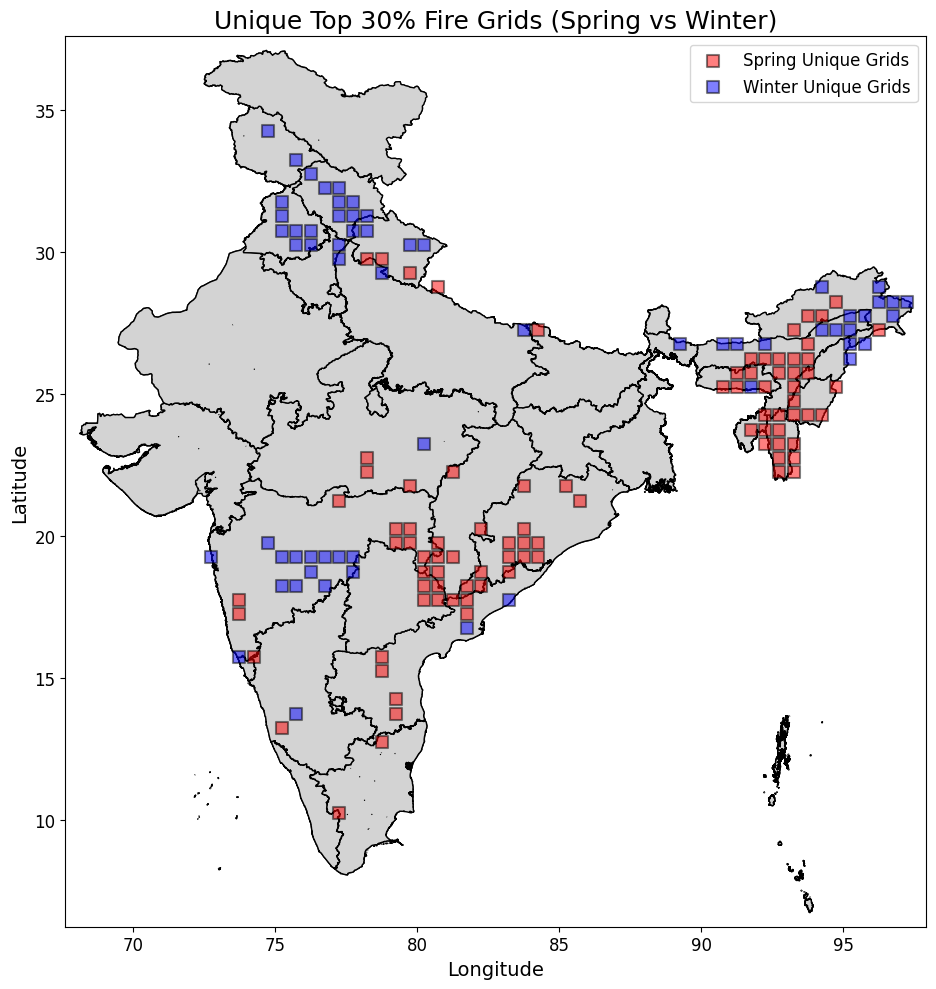

In [17]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load India shapefile and fire data
india_shapefile = "india.shp"
india_map = gpd.read_file(india_shapefile)

fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract year and month
fire_data['year'] = fire_data['year_month'].str[:4]
fire_data['month'] = fire_data['year_month'].str[5:7]

# Define seasonal groups
spring_months = ["02", "03", "04", "05"]
winter_months = ["10", "11", "12", "01"]

# Split data into seasons
spring_data = fire_data[fire_data['month'].isin(spring_months)]
winter_data = fire_data[fire_data['month'].isin(winter_months)]

# Count fires per grid for each season
spring_grid_counts = spring_data.groupby(['lat', 'lon']).size().reset_index(name='fire_count')
winter_grid_counts = winter_data.groupby(['lat', 'lon']).size().reset_index(name='fire_count')

# Get top 30% grids for each season
spring_threshold = spring_grid_counts['fire_count'].quantile(0.7)
winter_threshold = winter_grid_counts['fire_count'].quantile(0.7)

top_spring_grids = spring_grid_counts[spring_grid_counts['fire_count'] >= spring_threshold]
top_winter_grids = winter_grid_counts[winter_grid_counts['fire_count'] >= winter_threshold]

# Identify unique grids for each season
spring_set = set(zip(top_spring_grids['lat'], top_spring_grids['lon']))
winter_set = set(zip(top_winter_grids['lat'], top_winter_grids['lon']))

spring_unique = spring_set - winter_set
winter_unique = winter_set - spring_set

spring_unique_df = pd.DataFrame(list(spring_unique), columns=['lat', 'lon'])
winter_unique_df = pd.DataFrame(list(winter_unique), columns=['lat', 'lon'])

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))
india_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot unique grids for spring (red) and winter (blue)
ax.scatter(
    spring_unique_df['lon'],
    spring_unique_df['lat'],
    color='red',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',
    linewidth=1.5,
    label="Spring Unique Grids"
)

ax.scatter(
    winter_unique_df['lon'],
    winter_unique_df['lat'],
    color='blue',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',
    linewidth=1.5,
    label="Winter Unique Grids"
)

# Customize plot appearance
ax.set_title("Unique Top 30% Fire Grids (Spring vs Winter)", fontsize=18)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set limits to fit India map
ax.set_xlim([india_map.total_bounds[0] - 0.5, india_map.total_bounds[2] + 0.5])
ax.set_ylim([india_map.total_bounds[1] - 0.5, india_map.total_bounds[3] + 0.5])

plt.tight_layout()
plt.savefig("unique_seasonal_fire_hotspots_one_image.png", dpi=500)
plt.show()


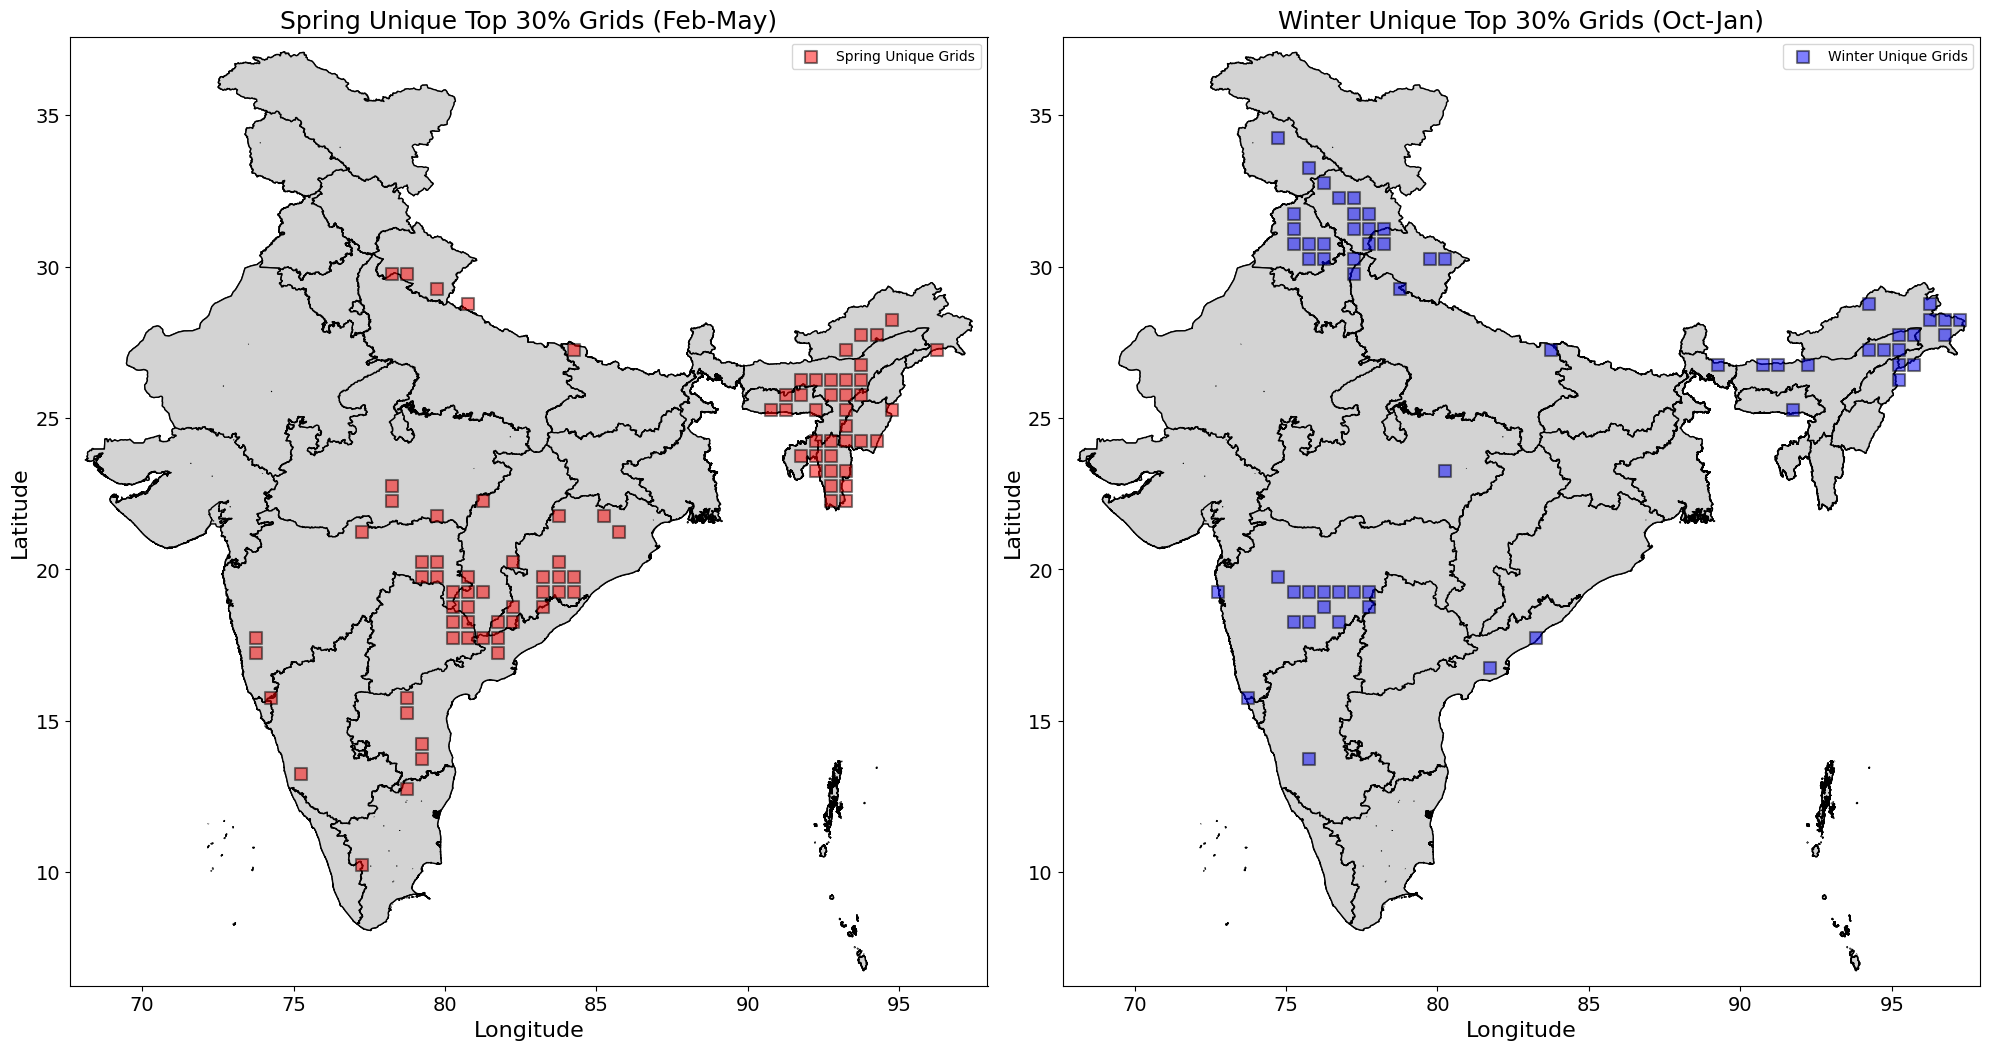

In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load India shapefile and fire data
india_shapefile = "india.shp"
india_map = gpd.read_file(india_shapefile)

fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract year and month
fire_data['year'] = fire_data['year_month'].str[:4]
fire_data['month'] = fire_data['year_month'].str[5:7]

# Define seasonal groups
spring_months = ["02", "03", "04", "05"]
winter_months = ["10", "11", "12", "01"]

# Split data into seasons
spring_data = fire_data[fire_data['month'].isin(spring_months)]
winter_data = fire_data[fire_data['month'].isin(winter_months)]

# Count fires per grid for each season
spring_grid_counts = spring_data.groupby(['lat', 'lon']).size().reset_index(name='fire_count')
winter_grid_counts = winter_data.groupby(['lat', 'lon']).size().reset_index(name='fire_count')

# Get top 30% grids for each season
spring_threshold = spring_grid_counts['fire_count'].quantile(0.7)
winter_threshold = winter_grid_counts['fire_count'].quantile(0.7)

top_spring_grids = spring_grid_counts[spring_grid_counts['fire_count'] >= spring_threshold]
top_winter_grids = winter_grid_counts[winter_grid_counts['fire_count'] >= winter_threshold]

# Identify unique grids for each season
spring_set = set(zip(top_spring_grids['lat'], top_spring_grids['lon']))
winter_set = set(zip(top_winter_grids['lat'], top_winter_grids['lon']))

spring_unique = spring_set - winter_set
winter_unique = winter_set - spring_set

spring_unique_df = pd.DataFrame(list(spring_unique), columns=['lat', 'lon'])
winter_unique_df = pd.DataFrame(list(winter_unique), columns=['lat', 'lon'])

# Set up the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 11))

# Background map for both plots
for ax in axes:
    india_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Spring Unique Grids
axes[0].scatter(
    spring_unique_df['lon'],
    spring_unique_df['lat'],
    color='red',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',
    linewidth=1.5,
    label="Spring Unique Grids"
)
axes[0].set_title("Spring Unique Top 30% Grids (Feb-May)", fontsize=18)
axes[0].set_xlabel("Longitude", fontsize=16)
axes[0].set_ylabel("Latitude", fontsize=16)
axes[0].legend()
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_xlim([india_map.total_bounds[0] - 0.5, india_map.total_bounds[2] + 0.5])
axes[0].set_ylim([india_map.total_bounds[1] - 0.5, india_map.total_bounds[3] + 0.5])

# Plot Winter Unique Grids
axes[1].scatter(
    winter_unique_df['lon'],
    winter_unique_df['lat'],
    color='blue',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',
    linewidth=1.5,
    label="Winter Unique Grids"
)
axes[1].set_title("Winter Unique Top 30% Grids (Oct-Jan)", fontsize=18)
axes[1].set_xlabel("Longitude", fontsize=16)
axes[1].set_ylabel("Latitude", fontsize=16)
axes[1].legend()
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlim([india_map.total_bounds[0] - 0.5, india_map.total_bounds[2] + 0.5])
axes[1].set_ylim([india_map.total_bounds[1] - 0.5, india_map.total_bounds[3] + 0.5])

plt.tight_layout()
plt.savefig("unique_seasonal_fire_grids_side_by_side.png", dpi=500)
plt.show()


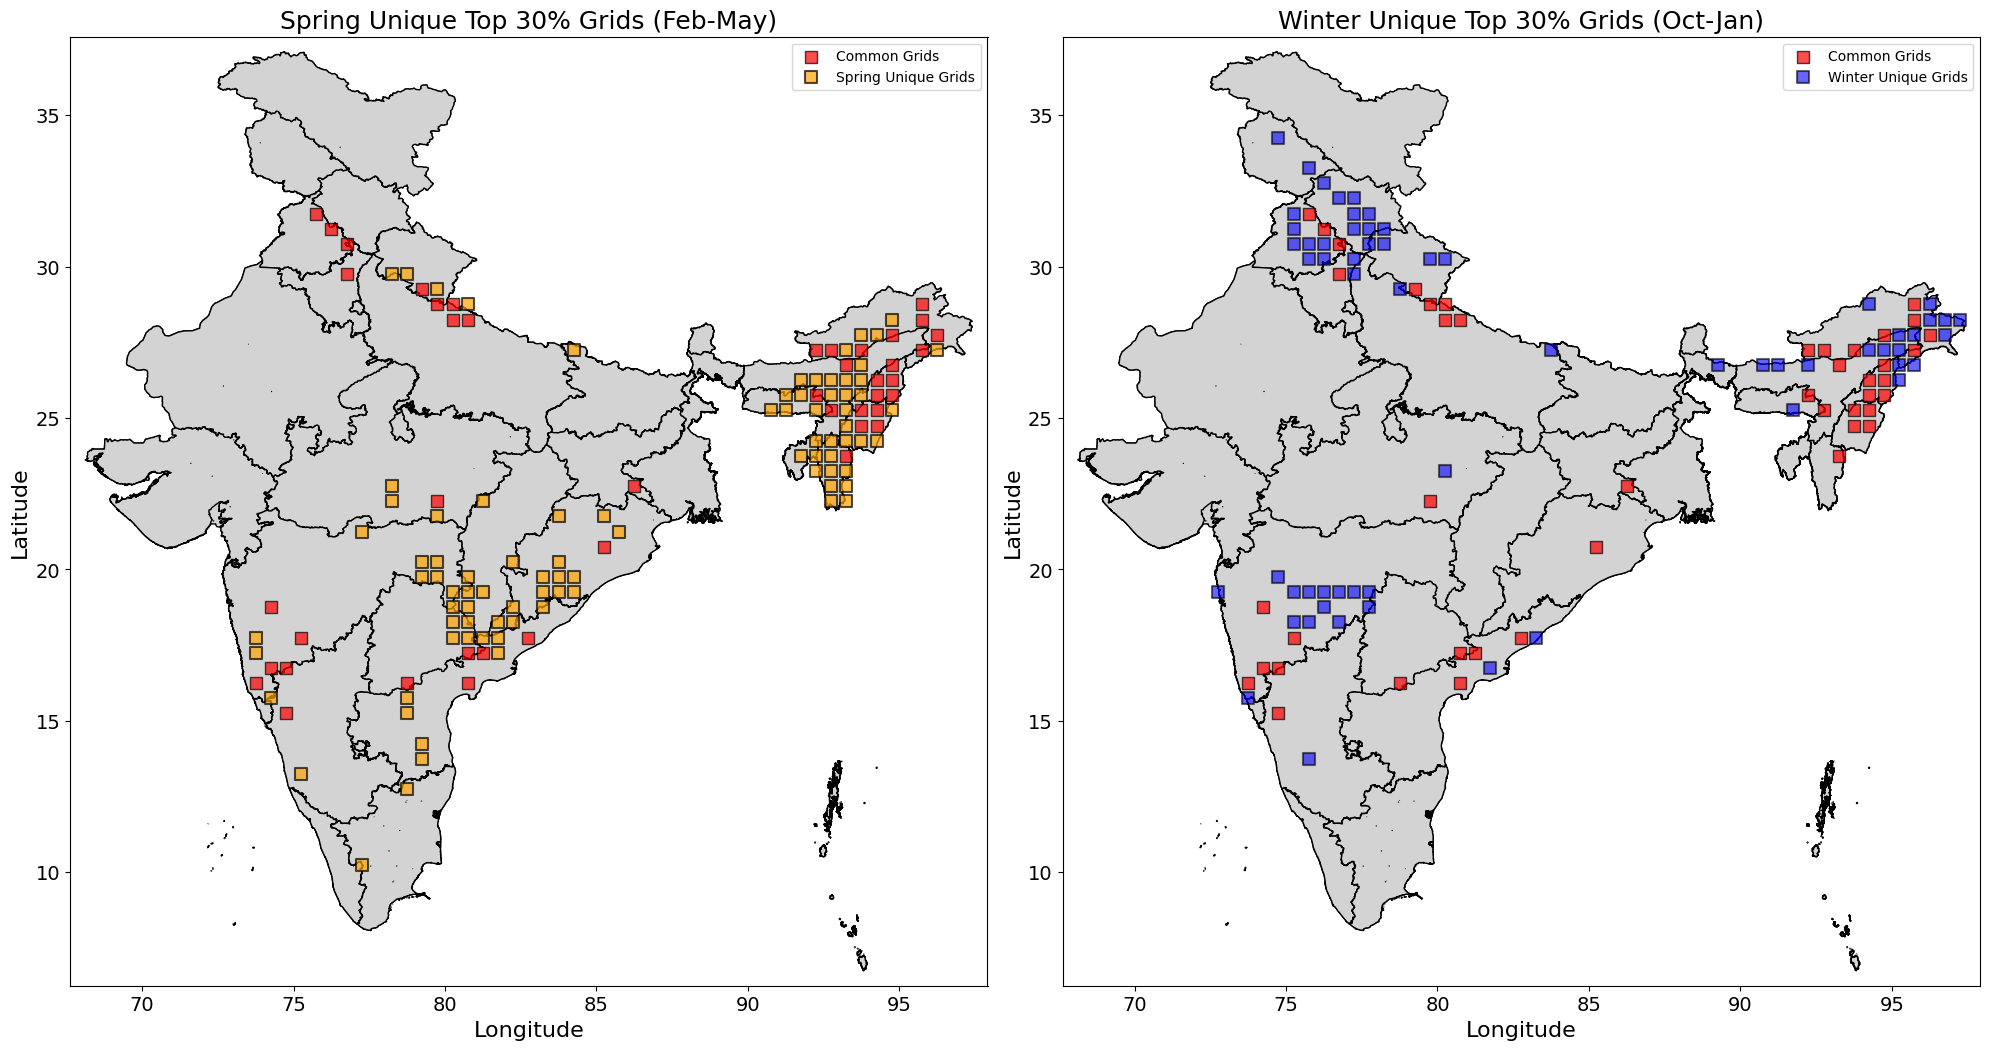

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load India shapefile and fire data
india_shapefile = "india.shp"
india_map = gpd.read_file(india_shapefile)

fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract year and month
fire_data['year'] = fire_data['year_month'].str[:4]
fire_data['month'] = fire_data['year_month'].str[5:7]

# Define seasonal groups
spring_months = ["02", "03", "04", "05"]
winter_months = ["10", "11", "12", "01"]

# Split data into seasons
spring_data = fire_data[fire_data['month'].isin(spring_months)]
winter_data = fire_data[fire_data['month'].isin(winter_months)]

# Count fires per grid for each season
spring_grid_counts = spring_data.groupby(['lat', 'lon']).size().reset_index(name='fire_count')
winter_grid_counts = winter_data.groupby(['lat', 'lon']).size().reset_index(name='fire_count')

# Get top 30% grids for each season
spring_threshold = spring_grid_counts['fire_count'].quantile(0.7)
winter_threshold = winter_grid_counts['fire_count'].quantile(0.7)

top_spring_grids = spring_grid_counts[spring_grid_counts['fire_count'] >= spring_threshold]
top_winter_grids = winter_grid_counts[winter_grid_counts['fire_count'] >= winter_threshold]

# Identify unique and common grids
spring_set = set(zip(top_spring_grids['lat'], top_spring_grids['lon']))
winter_set = set(zip(top_winter_grids['lat'], top_winter_grids['lon']))

common_grids = spring_set & winter_set  # Grids present in both
spring_unique = spring_set - winter_set  # Grids only in spring
winter_unique = winter_set - spring_set  # Grids only in winter

# Convert to DataFrames
spring_unique_df = pd.DataFrame(list(spring_unique), columns=['lat', 'lon'])
winter_unique_df = pd.DataFrame(list(winter_unique), columns=['lat', 'lon'])
common_df = pd.DataFrame(list(common_grids), columns=['lat', 'lon'])

# Set up the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 11))

# Background map for both plots
for ax in axes:
    india_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Common Grids (Grey) on Both Plots
for ax in axes:
    ax.scatter(
        common_df['lon'], common_df['lat'],
        color='red', s=70, marker='s', alpha=0.7, edgecolor='black', linewidth=1,
        label="Common Grids"
    )

# Plot Spring Unique Grids (Red)
axes[0].scatter(
    spring_unique_df['lon'], spring_unique_df['lat'],
    color='orange', s=70, marker='s', alpha=0.7, edgecolor='black', linewidth=1.5,
    label="Spring Unique Grids"
)
axes[0].set_title("Spring Unique Top 30% Grids (Feb-May)", fontsize=18)
axes[0].set_xlabel("Longitude", fontsize=16)
axes[0].set_ylabel("Latitude", fontsize=16)
axes[0].legend()
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_xlim([india_map.total_bounds[0] - 0.5, india_map.total_bounds[2] + 0.5])
axes[0].set_ylim([india_map.total_bounds[1] - 0.5, india_map.total_bounds[3] + 0.5])

# Plot Winter Unique Grids (Blue)
axes[1].scatter(
    winter_unique_df['lon'], winter_unique_df['lat'],
    color='blue', s=70, marker='s', alpha=0.6, edgecolor='black', linewidth=1.5,
    label="Winter Unique Grids"
)
axes[1].set_title("Winter Unique Top 30% Grids (Oct-Jan)", fontsize=18)
axes[1].set_xlabel("Longitude", fontsize=16)
axes[1].set_ylabel("Latitude", fontsize=16)
axes[1].legend()
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlim([india_map.total_bounds[0] - 0.5, india_map.total_bounds[2] + 0.5])
axes[1].set_ylim([india_map.total_bounds[1] - 0.5, india_map.total_bounds[3] + 0.5])

plt.tight_layout()
plt.savefig("unique_seasonal_fire_grids_with_common.png", dpi=500)
plt.show()


In [20]:
# Load fire data file
fire_df = pd.read_csv("fire_archive_M-C61_570219.csv")  # Fire data with 'latitude' and 'longitude' columns

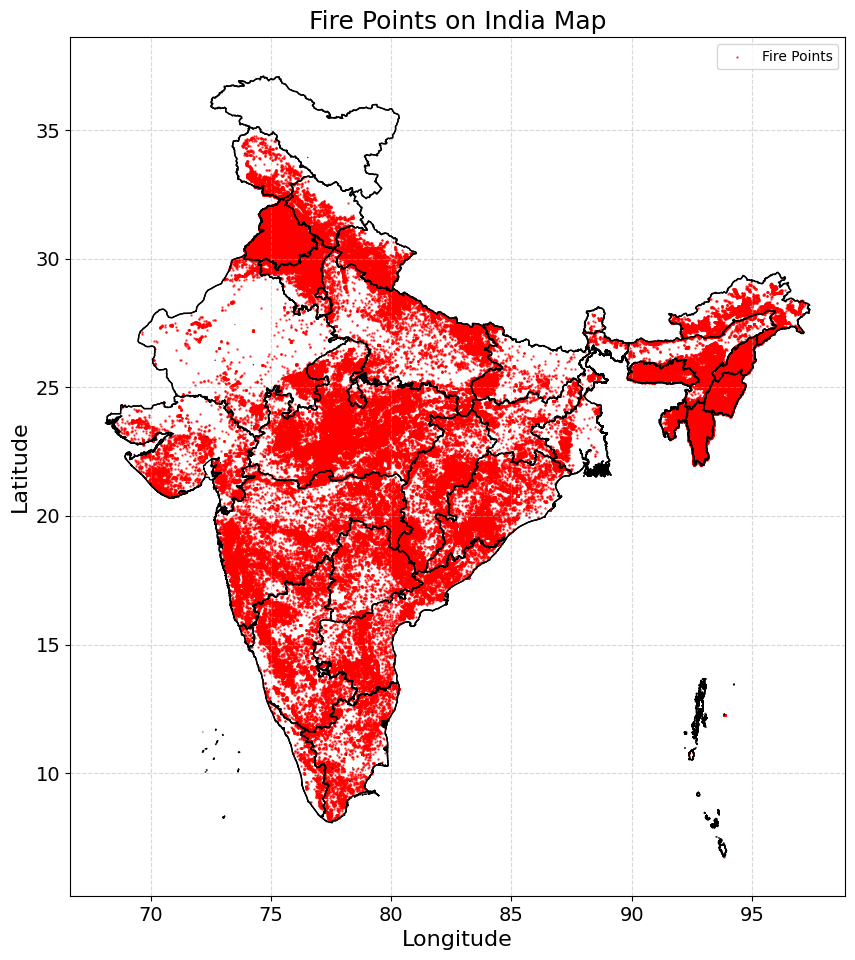

In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the fire data
fire_data = pd.read_csv("fire_archive_M-C61_570219.csv")

# Filter data by confidence
fire_data = fire_data[fire_data['confidence'] > 75]

# Load the India shapefile
india_map = gpd.read_file('india.shp')

# Convert fire data to GeoDataFrame
fire_gdf = gpd.GeoDataFrame(
    fire_data,
    geometry=gpd.points_from_xy(fire_data['longitude'], fire_data['latitude']),
    crs='EPSG:4326'  # WGS84 Coordinate System
)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 12))
india_map.boundary.plot(ax=ax, linewidth=1,color='black')
fire_gdf.plot(ax=ax, color='red', markersize=0.5, alpha=0.7, label='Fire Points')

# Customize the plot
plt.title('Fire Points on India Map', fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
# Save the figure as a high-DPI PNG
plt.savefig("fire_points.png", dpi=500, bbox_inches='tight')
plt.show()

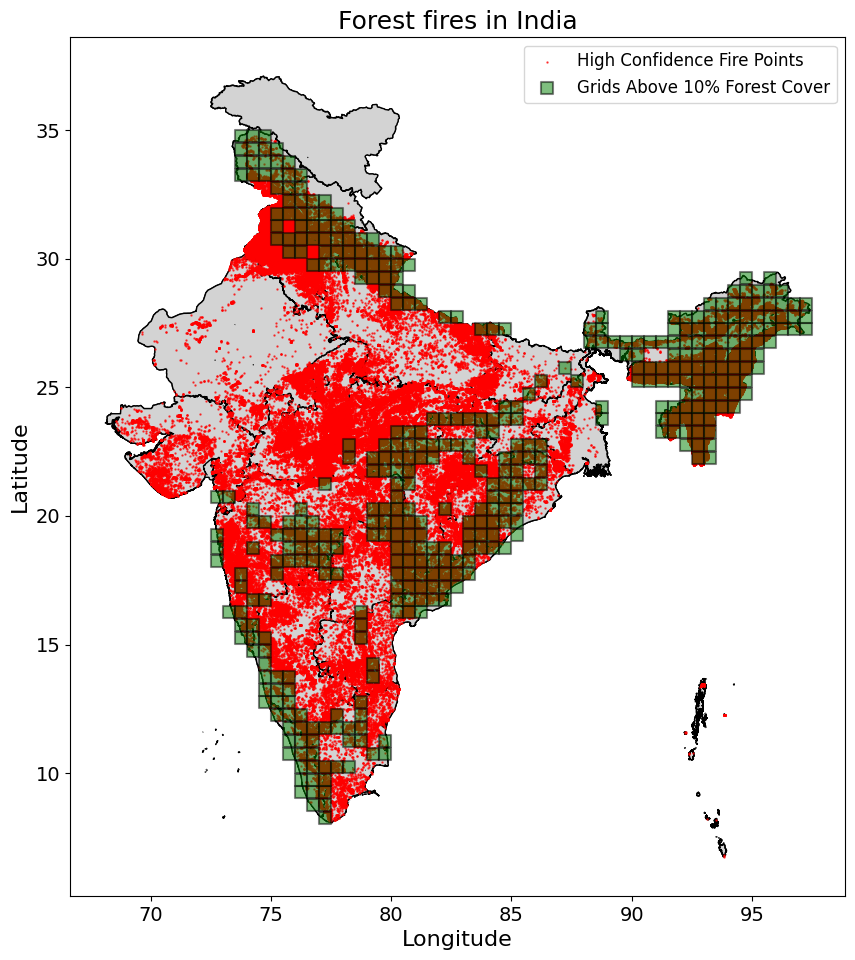

In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the fire data
fire_data = pd.read_csv("fire_archive_M-C61_570219.csv")

# Filter data by confidence
fire_data = fire_data[fire_data['confidence'] > 75]

# Load the India shapefile
india_shapefile = "india.shp"
india_map = gpd.read_file(india_shapefile)

# Convert fire data to GeoDataFrame
fire_gdf = gpd.GeoDataFrame(
    fire_data,
    geometry=gpd.points_from_xy(fire_data['longitude'], fire_data['latitude']),
    crs='EPSG:4326'  # WGS84 Coordinate System
)

# Load the grid data
grid_data_file = "above_10_fc_w_fire.csv"
grid_data = pd.read_csv(grid_data_file)
unique_grid_data = grid_data[['lat', 'lon']].drop_duplicates()

# Plot the map
fig, ax = plt.subplots(figsize=(10, 12))

# Plot India map
india_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot fire data points (round markers)
fire_gdf.plot(ax=ax, color='red', markersize=0.5, alpha=0.7, label='High Confidence Fire Points')

# Plot grid data (square markers)
plt.scatter(
    unique_grid_data['lon'],
    unique_grid_data['lat'],
    color='green',
    s=70,
    marker='s',
    alpha=0.5,
    edgecolor='black',
    linewidth=1.5,
    label="Grids Above 10% Forest Cover"
)

# Customize the plot
plt.title('Forest fires in India', fontsize=18)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=12)

# Save the figure as a high-DPI PNG
plt.savefig("High_Confidence_Fire_Points_and_Grids.png", dpi=500, bbox_inches='tight')
plt.show()


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the forest fire data file
fire_data_file = "above_10_fc_w_fire.csv"
fire_data = pd.read_csv(fire_data_file)

# Extract the year from the year_month column
fire_data['year'] = fire_data['year_month'].str[:4]

# Convert year to integer for filtering and sorting
fire_data['year'] = fire_data['year'].astype(int)

# Keep only the years from 2015 to 2023
fire_data = fire_data[(fire_data['year'] >= 2015) & (fire_data['year'] <= 2023)]

# Compute the total yearly fire count across all grids
yearly_fire_count = fire_data.groupby('year')['count'].size().reset_index(name='fire_count')

# Sort by year in ascending order
yearly_fire_count = yearly_fire_count.sort_values(by='year')

# Export the yearly fire count data to a CSV file
yearly_fire_count.to_csv("yearly_fire_counts.csv", index=False)

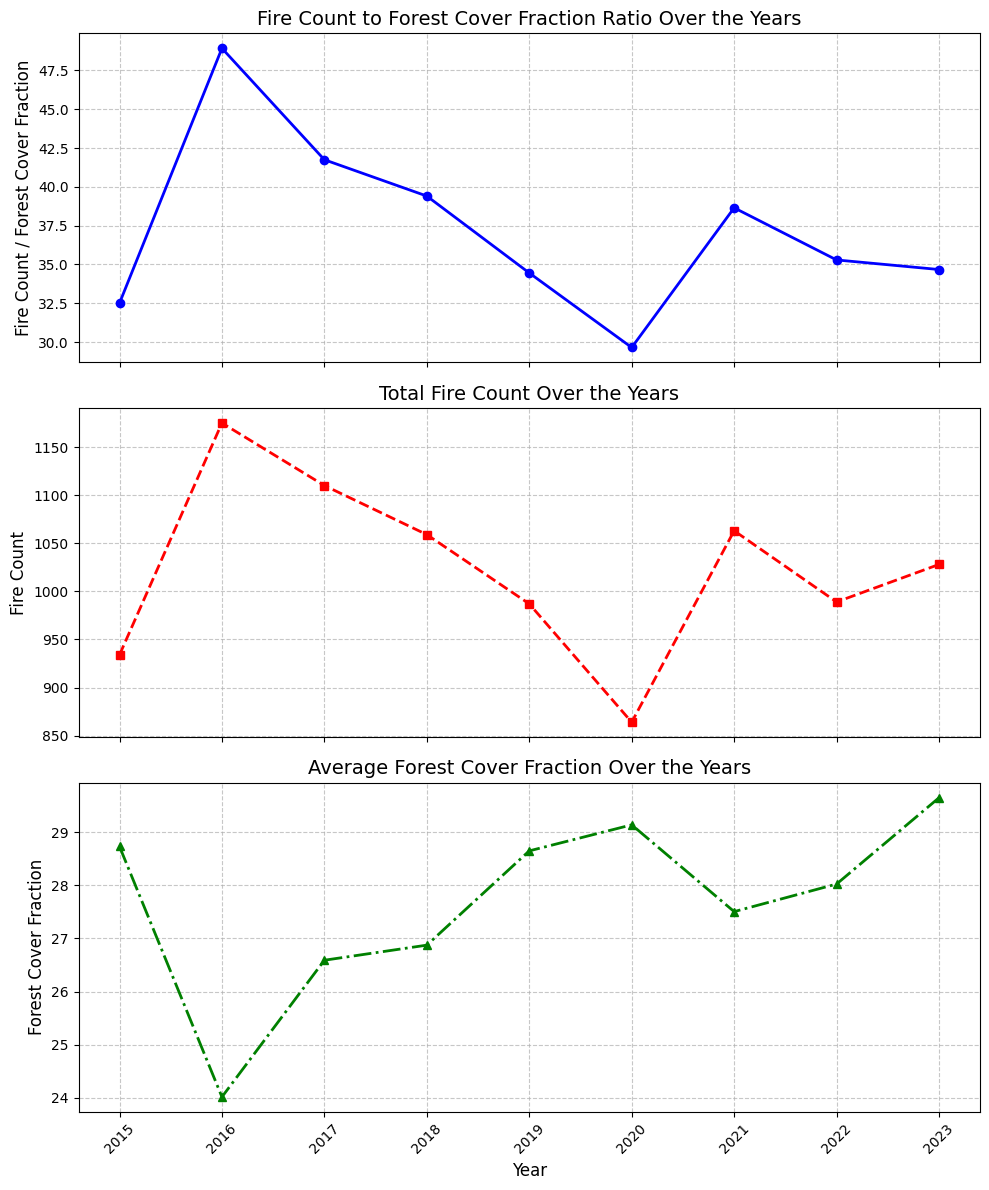

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the forest cover and fire count data
forest_cover_file = "yearly_forest_cover.csv"
forest_cover_data = pd.read_csv(forest_cover_file)

fire_file = "yearly_fire_counts.csv"
fire_data = pd.read_csv(fire_file)

# Compute the ratio of fire count to forest cover fraction
forest_cover_data['fire_ratio'] = fire_data['fire_count'] / forest_cover_data['Avg_ForestCoverFraction']

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Fire Ratio Plot
axes[0].plot(forest_cover_data['Year'], forest_cover_data['fire_ratio'], marker='o', linestyle='-', color='blue', linewidth=2)
axes[0].set_ylabel("Fire Count / Forest Cover Fraction", fontsize=12)
axes[0].set_title("Fire Count to Forest Cover Fraction Ratio Over the Years", fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Fire Count Plot
axes[1].plot(forest_cover_data['Year'], fire_data['fire_count'], marker='s', linestyle='--', color='red', linewidth=2)
axes[1].set_ylabel("Fire Count", fontsize=12)
axes[1].set_title("Total Fire Count Over the Years", fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Forest Cover Fraction Plot
axes[2].plot(forest_cover_data['Year'], forest_cover_data['Avg_ForestCoverFraction'], marker='^', linestyle='-.', color='green', linewidth=2)
axes[2].set_xlabel("Year", fontsize=12)
axes[2].set_ylabel("Forest Cover Fraction", fontsize=12)
axes[2].set_title("Average Forest Cover Fraction Over the Years", fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()